In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

1.Load the dataset

In [2]:
# Load the dataset
file_path = 'data\processed\Los_Angeles_Accidents_Agreagated_2016_2023.csv'
accident_data = pd.read_csv(file_path)
print(accident_data)

     Accident_Date  Severity  Temperature(F) Weather_Condition  Humidity(%)  \
0       2016-03-22  2.400000       63.040000             Clear    26.000000   
1       2016-03-23  2.529412       68.491176             Clear    29.794118   
2       2016-03-24  2.485294       68.372059             Clear    33.544118   
3       2016-03-25  2.533333       65.831111             Clear    56.088889   
4       2016-03-26  2.736842       64.394737             Clear    70.631579   
...            ...       ...             ...               ...          ...   
2488    2023-03-27  2.000000       62.089888              Fair    28.528090   
2489    2023-03-28  2.000000       61.981982              Fair    37.765766   
2490    2023-03-29  2.014706       52.264706              Rain    80.794118   
2491    2023-03-30  2.000000       51.096774            Cloudy    75.322581   
2492    2023-03-31  2.000000       60.051282              Fair    57.076923   

      Pressure(in)  Visibility(mi)  Wind_Speed(mph)

2. Define X and Y, drop necessary columns and handle both numerical and categorical features.

In [3]:
# Define features and target
features = accident_data.drop(columns=['Accident_Date', 'Severity'])
target = accident_data['total_accidents']

# Define categorical and numerical features
categorical_features = ['Weather_Condition', 'is_weekend', 'is_holiday']
numerical_features = [col for col in features.columns if col not in categorical_features]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(features)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, target, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1745, 25), (748, 25), (1745,), (748,))

3. Using KNN Model

Best Number of Neighbors: 35
Best Test Accuracy: 0.0361


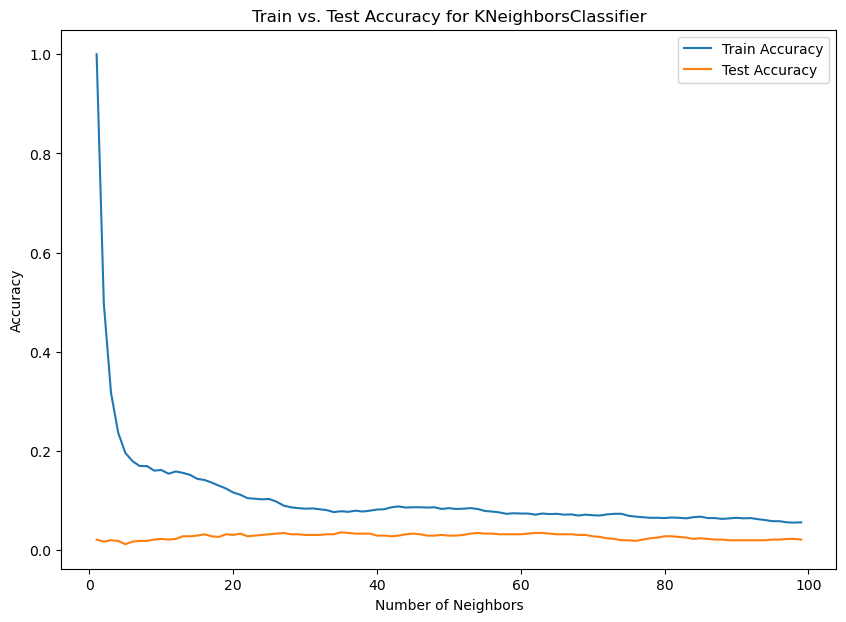

In [4]:
# Assuming X_preprocessed and target are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, target, test_size=0.3, random_state=42)

train_accuracies = []
test_accuracies = []
best_n_neighbors = None
best_test_accuracy = 0

# Train the KNN model with different numbers of neighbors
for n_neighbors in range(1, 100):  # Adjust range as needed
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    
    # Evaluate accuracy on the training data
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Evaluate accuracy on the testing data
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Check if this is the best test accuracy
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_n_neighbors = n_neighbors

# Print the best number of neighbors and its corresponding accuracy
print(f'Best Number of Neighbors: {best_n_neighbors}')
print(f'Best Test Accuracy: {best_test_accuracy:.4f}')

# Plot the train and test accuracies
plt.figure(figsize=(10, 7))
plt.plot(range(1, 100), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 100), test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Train vs. Test Accuracy for KNeighborsClassifier')
plt.legend()
plt.show()

4. Categorize the target into 3 classes and using the Neural Network Model.

In [5]:
# Categorizing the total_accidents into classes: low, medium, high
bins = [0, 67, 133, accident_data['total_accidents'].max()]
labels = ['low', 'medium', 'high']
accident_data['accident_class'] = pd.cut(accident_data['total_accidents'], bins=bins, labels=labels)

# Encode the labels
label_encoder = LabelEncoder()
accident_data['accident_class_encoded'] = label_encoder.fit_transform(accident_data['accident_class'])


# Selecting the features and target variable
X = accident_data[['Temperature(F)', 'Weather_Condition', 'Humidity(%)', 'Pressure(in)', 
          'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
          'accident_weekday', 'is_weekend', 'is_holiday', 
          'Accident_Year', 'Accident_Month', 'Accident_Day']]
y = to_categorical(accident_data['accident_class_encoded'])

# Convert categorical data to numerical
X = pd.get_dummies(X, columns=['Weather_Condition'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Initialize the neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=3, activation='softmax'))  # Output layer with 3 classes

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
63/63 [==============================] - 1s 5ms/step - loss: 0.8647 - accuracy: 0.6219 - val_loss: 0.7300 - val_accuracy: 0.6774
Epoch 2/50
63/63 [==============================] - 0s 2ms/step - loss: 0.6795 - accuracy: 0.7011 - val_loss: 0.6729 - val_accuracy: 0.7034
Epoch 3/50
63/63 [==============================] - 0s 2ms/step - loss: 0.6300 - accuracy: 0.7377 - val_loss: 0.6528 - val_accuracy: 0.7255
Epoch 4/50
63/63 [==============================] - 0s 2ms/step - loss: 0.5964 - accuracy: 0.7523 - val_loss: 0.6324 - val_accuracy: 0.7295
Epoch 5/50
63/63 [==============================] - 0s 2ms/step - loss: 0.5741 - accuracy: 0.7638 - val_loss: 0.6309 - val_accuracy: 0.7295
Epoch 6/50
63/63 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7643 - val_loss: 0.6227 - val_accuracy: 0.7114
Epoch 7/50
63/63 [==============================] - 0s 2ms/step - loss: 0.5547 - accuracy: 0.7733 - val_loss: 0.6189 - val_accuracy: 0.7214
Epoch 8/50
63/63 [==

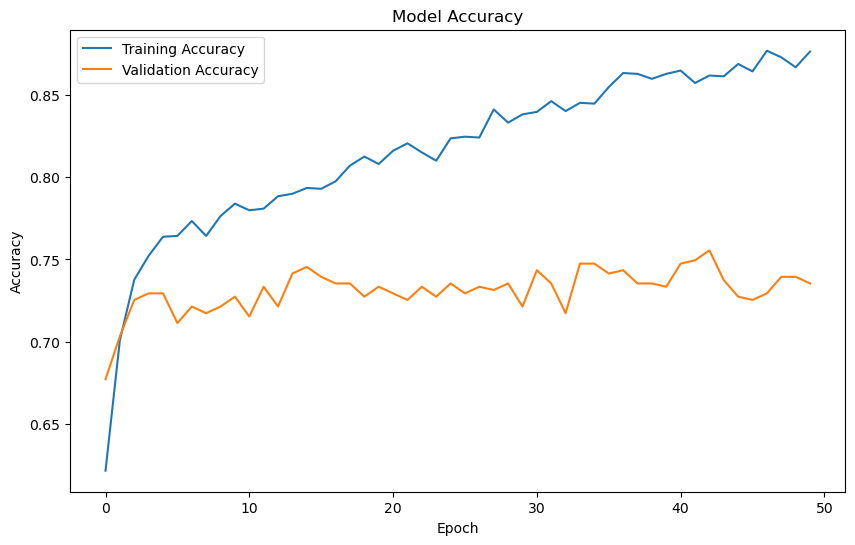

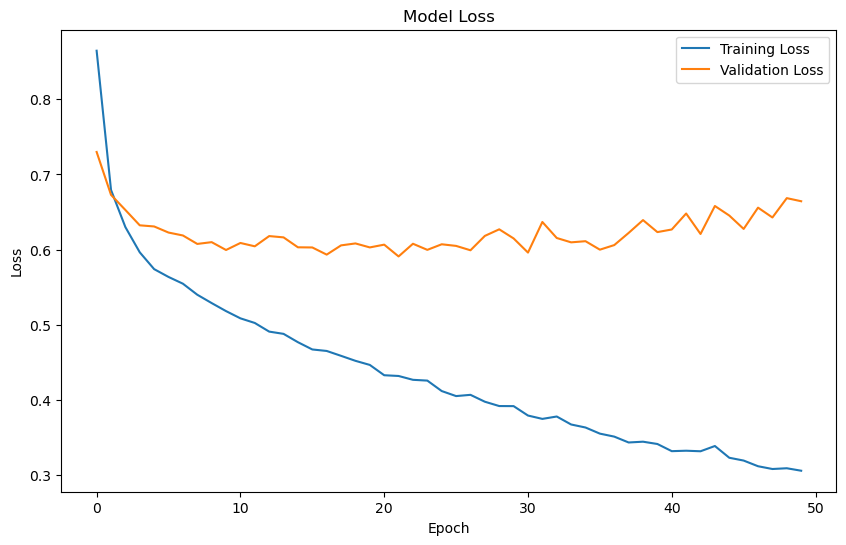

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Conclusion:
Initially, I have applied the KNN algorithm to predict the number of total accidents (y) by different features(x), and the model was tuned to find the best number of neighbors.
The results of K-Nearest Neighbors (KNN) Model is not ideal, which means Best Number of Neighbors: 35 and Best Test Accuracy: 3.61%.
I think that is because firstly, the dataset has imbalanced classes, secondly, the underlying decision boundary is complex, that KNN model might not be able to capture it effectively.
So I decide to categorize the total_accidents into three classes (low, medium, high) evenly, and built a neural network model to classify accident severity.
The results of the neural network model is significantly outperformed the KNN model, achieving a test accuracy of 73.55%. This indicates that the neural network was much better at capturing complex dataset after converting the target variable into categorical classes and likely due to its ability to model complex, non-linear relationships.